#Coronary heart disease prediction
This notebook uses machine learning methods to predict coronary heart disease in patients. Dataset used is fairly old (from 1988), but it had new records added to it.

---
####About dataset
Dataset contains 76 variables, one of which is target variable named 'num'. It has diagnosis of disease (they are valued 0,1,2,3 or 4 - here we will change it to be either 0 or 1) A lot of variables has a lot of missing values. With new data added, it has 2440 observations. In the original paper authors used only use 13 variables to make predictions. We will consider three datasets, depending on number of variables.

---
####Methods used
As said above, we consider three datasets with varying number variables. We will use two logistic regression - one with lasso penalty and one with ridge penalty. We will also use nine neural network models. They will vary on regularization and number of hidden layers. In total considering all datasets and types of models, we will compare *33 different models*. Due to large amount of missing values, we also implement *autoencoder imputation*.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import pickle

from tqdm import tqdm
from time import time
from google.colab import drive
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", message=".*was called on layer.*")

learning = False


Set 'learning' parameter to False if you have weights and don't want to relearn weights of neural networks. Otherwise, set 'learning' parameter to True.

In [3]:
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/heart+disease.zip' .
!unzip heart+disease.zip

Mounted at /content/drive
Archive:  heart+disease.zip
  inflating: Index                   
  inflating: WARNING                 
  inflating: ask-detrano             
  inflating: bak                     
  inflating: cleve.mod               
  inflating: cleveland.data          
   creating: costs/
  inflating: costs/Index             
  inflating: costs/heart-disease.README  
  inflating: costs/heart-disease.cost  
  inflating: costs/heart-disease.delay  
  inflating: costs/heart-disease.expense  
  inflating: costs/heart-disease.group  
  inflating: heart-disease.names     
  inflating: hungarian.data          
  inflating: long-beach-va.data      
  inflating: new.data                
  inflating: processed.cleveland.data  
  inflating: processed.hungarian.data  
  inflating: processed.switzerland.data  
  inflating: processed.va.data       
  inflating: reprocessed.hungarian.data  
  inflating: switzerland.data        


In [4]:
if not learning:
  !cp '/content/drive/MyDrive/deep_learning_weights.zip' .
  !unzip deep_learning_weights

Archive:  deep_learning_weights.zip
  inflating: NN_weights13.pkl        
  inflating: NN_weights46.pkl        
  inflating: NN_weights62.pkl        
  inflating: AE13.pkl                
  inflating: AE46.pkl                
  inflating: AE62.pkl                
  inflating: history13.pkl           
  inflating: history46.pkl           
  inflating: history62.pkl           


In [5]:
start = time()
colnames = ['id', 'cff', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp',
            'trestbps', 'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist',
            'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic',
            'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps',
            'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5',
            'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 'exeref', 'exerwm',
            'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 'lmt',
            'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist',
            'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name']

##Data loading and preprocessing

In [6]:
#Data from: switzerland, long-beach-va, hungarian, cleveland, "new"
with open('cleveland.data', encoding = 'latin-1') as f:
  data = []
  string = ''
  lines = f.readlines()[:2820]
  for l in lines:
    string += l
    if l.strip()[-1] == 'e':
      data.append(string.split())
      string = ''

df_cleveland = pd.DataFrame(data)
df_cleveland.columns = colnames

with open('switzerland.data') as f:
  data = []
  string = ''
  lines = f.readlines()
  for l in lines:
    string += l
    if l.strip()[-1] == 'e':
      data.append(string.split())
      string = ''

df_switzerland = pd.DataFrame(data)
df_switzerland.columns = colnames

with open('hungarian.data') as f:
  data = []
  string = ''
  lines = f.readlines()[:-1]
  for l in lines:
    string += l
    if l.strip()[-1] == 'e':
      data.append(string.split())
      string = ''

df_hungarian = pd.DataFrame(data)
df_hungarian.columns = colnames

with open('long-beach-va.data') as f:
  data = []
  string = ''
  lines = f.readlines()[:-1]
  for l in lines:
    string += l
    if l.strip()[-1] == 'e':
      data.append(string.split())
      string = ''

df_longbeach = pd.DataFrame(data)
df_longbeach.columns = colnames

with open('new.data') as f:
  data = []
  string = ''
  lines = f.readlines()
  for l in lines:
    string += l
    if l.strip()[-1].isalpha():
      data.append(string.split())
      string = ''

df_new = pd.DataFrame(data)
df_new = df_new.drop(df_new.columns[[i for i in range(75, 89)]], axis=1)
df_new.columns = colnames

#adding new variable to account for place
df_cleveland['place'] = 1
df_switzerland['place'] = 2
df_hungarian['place'] = 3
df_longbeach['place'] = 4
df_new['place'] = 5

df = pd.concat([df_cleveland, df_switzerland, df_hungarian, df_longbeach, df_new])
df.reset_index(drop=True, inplace=True)
df.shape

(2440, 77)

In [7]:
df = df.replace('-9', np.nan)
df = df.replace('-9.', np.nan)

/tmp/ipython-input-7-2942906600.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('-9', np.nan)


In [8]:
for col in df.columns:
  if df[col].unique().size == 1 or df[col].unique().size == 2:
    print(col, df[col].unique())

sex ['1' '0']
restckm [nan]
exerckm [nan '0']
earlobe [nan '0']


After simple data analysis we find that:
*   Variable 'restckm' has only missing values, while variables 'exerckm' and 'earlobe' have missing values or '0'.
*   Variable 'pncaden' is sum of three other variables
*   Variables 'id', 'cff' (this is social security number), 'name', 'ekgday', 'ekgmo', 'ekgyr', 'cday', 'cmo', 'cyr' are irrelevant from point of view of prediction.

Therefore, all variables above will be discarded from further analysis.

In [9]:
df = df.drop(['id', 'cff', 'name', 'dummy', 'ekgday', 'ekgmo', 'ekgyr', 'cday', 'cmo', 'cyr', 'pncaden', 'restckm', 'exerckm', 'earlobe'], axis=1)

First dataset will consist of recommended 13 variables, that were used in the original paper, and will be called 'X_recommended'. Second dataset will consist of all remaining variables, and will be called 'X_full'

In [10]:
recommended = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X_recommended = df[recommended]
X_array = np.array(X_recommended).astype(float)
X_array = np.where(np.isnan(X_array), np.nanmean(X_array, axis=0), X_array)
X_array.shape

(2440, 13)

In [11]:
X_full = df
X_full = X_full.drop('num', axis = 1)
X_full_array = np.array(X_full).astype(float)
X_full_array = np.where(np.isnan(X_full_array), np.nanmean(X_full_array, axis=0), X_full_array)
X_full_array.shape

(2440, 62)

In [12]:
df.isnull().mean().sort_values(ascending=False)[:20]
#dużo brakujących wartości

,0
exeref,0.997541
exerwm,0.995492
thalpul,0.974590
restef,0.963115
restwm,0.962705
thalsev,0.921311
junk,0.901639
ca,0.754098
smoke,0.741393
cathef,0.685246


In [13]:
#18 variables have more than 50% missing data
threshold = 0.5
missing_percent = df.isnull().mean()
df.loc[:, missing_percent > threshold].columns

Index(['smoke', 'cigs', 'years', 'famhist', 'rldv5', 'ca', 'restef', 'restwm',
       'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'diag', 'ramus',
       'om2', 'cathef', 'junk'],
      dtype='object')

By dropping variables mentioned above, we created third dataset - we will simply call it 'X'

In [14]:
#we will drop those variables that have more than 50% missing data, except for family history and if patient smokes cigarettes
col_del = df.loc[:, missing_percent > threshold].drop(['cigs', 'famhist'], axis = 1).columns
df = df.drop(col_del, axis = 1)

In [15]:
#Swapping target variable to '0-1'
df['num'] = np.where(df['num'] == '0', '0', '1')
df.shape

(2440, 47)

In [16]:
X = np.array(df.drop('num', axis=1)).astype(float)
X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
y = np.array(df['num']).astype(float)

##Autoencoder imputation

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.encoder_layer = Dense(units = self.hidden_dim, activation = tf.keras.activations.relu)

  def call(self, inputs):
    return self.encoder_layer(inputs)


class Decoder(tf.keras.layers.Layer):
  def __init__(self, original_dim):
    super(Decoder, self).__init__()
    self.original_dim = original_dim
    self.decoder_layer = Dense(units = self.original_dim, activation = tf.keras.activations.relu)

  def call(self, inputs):
    return self.decoder_layer(inputs)


class Autoencoder(tf.keras.Model):
  def __init__(self, hidden_dim, original_dim, **kwargs):
      super(Autoencoder, self).__init__(**kwargs)
      self.encoder = Encoder(hidden_dim)
      self.decoder = Decoder(original_dim)

  def call(self, inputs):
      encoded = self.encoder(inputs)
      decoded = self.decoder(encoded)
      return decoded

  def learn_ae(self, X_train, X_test, epochs = 10, batch_size = 32):
    self.build(input_shape=(None, X_train.shape[1], 1))
    self.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = tf.keras.losses.MeanSquaredError(), metrics = ['mse'])
    self.history = self.fit(X_train, X_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, X_test), verbose = 0)

In [18]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 2137)
X_recommended_train, X_recommended_test = train_test_split(X_array, test_size = 0.2, random_state = 2137)
X_full_train, X_full_test = train_test_split(X_full_array, test_size = 0.2, random_state = 2137)

##Autoencoder learning

In [19]:
if learning:
  ae46 = Autoencoder(20, X_train.shape[1])
  ae46.learn_ae(X_train, X_test)
  loss = ae46.history.history['val_loss'][-1]
  for i in tqdm(range(20)):
    ae46 = Autoencoder(20, X.shape[1])
    ae46.learn_ae(X_train, X_test, epochs = 100, batch_size = 32)
    if ae46.history.history['val_loss'][-1] < loss:
      loss = ae46.history.history['val_loss'][-1]
      best_weights46 = [ae46.layers[i].get_weights() for i in range(len(ae46.layers))]
      print(f"\nNew Best Loss: {loss}")

  print(f"\nBest loss: {loss}")

In [20]:
if learning:
  ae13 = Autoencoder(5, X_recommended_train.shape[1])
  ae13.learn_ae(X_recommended_train, X_recommended_test)
  loss = ae13.history.history['val_loss'][-1]
  for i in tqdm(range(20)):
    ae13 = Autoencoder(5, X_recommended_train.shape[1])
    ae13.learn_ae(X_recommended_train, X_recommended_test, epochs = 100, batch_size = 32)
    if ae13.history.history['val_loss'][-1] < loss:
      loss = ae13.history.history['val_loss'][-1]
      best_weights13 = [ae13.layers[i].get_weights() for i in range(len(ae13.layers))]
      print(f"\nNew Best Loss: {loss}")

  print(f"\nBest loss: {loss}")

In [21]:
if learning:
  ae62 = Autoencoder(30, X_full_train.shape[1])
  ae62.learn_ae(X_full_train, X_full_test)
  loss = ae62.history.history['val_loss'][-1]
  for i in tqdm(range(20)):
    ae62 = Autoencoder(30, X_full_train.shape[1])
    ae62.learn_ae(X_full_train, X_full_test, epochs = 100, batch_size = 32)
    if ae62.history.history['val_loss'][-1] < loss:
      loss = ae62.history.history['val_loss'][-1]
      best_weights62 = [ae62.layers[i].get_weights() for i in range(len(ae62.layers))]
      print(f"\nNew Best Loss: {loss}")

  print(f"\nBest loss: {loss}")

In [22]:
if learning:
  with open('AE46.pkl', 'wb') as f:
      pickle.dump(best_weights46, f)

  with open('AE13.pkl', 'wb') as f:
      pickle.dump(best_weights13, f)

  with open('AE62.pkl', 'wb') as f:
      pickle.dump(best_weights62, f)

##Missing data imputation

In [23]:
with open('AE46.pkl', 'rb') as f:
    best_weights46 = pickle.load(f)

ae46_2 = Autoencoder(20, X_train.shape[1])
ae46_2.learn_ae(X_train, X_test)
ae46_2.layers[0].set_weights(best_weights46[0])
ae46_2.layers[1].set_weights(best_weights46[1])
ae_pred = pd.DataFrame(ae46_2(X), columns=df.drop('num', axis = 1).columns)

rounded = ['thaldur', 'thaltime', 'met', 'oldpeak']
ae_pred[rounded] = ae_pred[rounded].round(1)
cols_to_cast = ae_pred.columns[~ae_pred.columns.isin(rounded)]
ae_pred[cols_to_cast] = ae_pred[cols_to_cast].astype(int)

X_new = df.drop('num', axis = 1)
X_new = X_new.fillna(ae_pred).astype(float)
X_new.head()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,cigs,...,cxmain,om1,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,place
0,63.0,1.0,0.0,0.0,0.0,1.0,145.0,1.0,233.0,50.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,67.0,1.0,0.0,0.0,0.0,4.0,160.0,1.0,286.0,40.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,67.0,1.0,0.0,0.0,0.0,4.0,120.0,1.0,229.0,20.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,7.0,3.0,1.0
3,37.0,1.0,0.0,0.0,0.0,3.0,130.0,0.0,250.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,41.0,0.0,0.0,0.0,0.0,2.0,130.0,1.0,204.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
with open('AE13.pkl', 'rb') as f:
    best_weights = pickle.load(f)

ae13_2 = Autoencoder(5, X_recommended_train.shape[1])
ae13_2.learn_ae(X_recommended_train, X_recommended_test)
ae13_2.layers[0].set_weights(best_weights[0])
ae13_2.layers[1].set_weights(best_weights[1])
ae_recommended_pred = pd.DataFrame(ae13_2(X_array), columns=recommended)

ae_recommended_pred['oldpeak'] = ae_recommended_pred['oldpeak'].round(1)
cols_to_cast = ae_recommended_pred.columns.difference(['oldpeak'])
ae_recommended_pred[cols_to_cast] = ae_recommended_pred[cols_to_cast].astype(int)

X_recommended_new = X_recommended.fillna(ae_recommended_pred).astype(float)
X_recommended_new.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [25]:
with open('AE62.pkl', 'rb') as f:
    best_weights62 = pickle.load(f)

ae62_2 = Autoencoder(30, X_full_train.shape[1])
ae62_2.learn_ae(X_full_train, X_full_test)
ae62_2.layers[0].set_weights(best_weights62[0])
ae62_2.layers[1].set_weights(best_weights62[1])
ae_full_pred = pd.DataFrame(ae62_2(X_full_array), columns=X_full.columns)

rounded_full = ['cathef', 'restef', 'oldpeak', 'met', 'thaltime', 'thaldur', 'chol']
ae_full_pred[rounded_full] = ae_full_pred[rounded_full].round(1)
cols_to_cast = ae_pred.columns[~ae_pred.columns.isin(rounded_full)]
ae_full_pred[cols_to_cast] = ae_full_pred[cols_to_cast].astype(int)

X_full_new = X_full.fillna(ae_full_pred).astype(float)
X_full_new.head()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,...,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,place
0,63.0,1.0,0.0,0.0,0.0,1.0,145.0,1.0,233.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,48.200001,5.991184,1.0
1,67.0,1.0,0.0,0.0,0.0,4.0,160.0,1.0,286.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,48.099998,5.624898,1.0
2,67.0,1.0,0.0,0.0,0.0,4.0,120.0,1.0,229.0,0.0,...,2.0,2.0,1.0,1.0,1.0,7.0,3.0,48.200001,5.550423,1.0
3,37.0,1.0,0.0,0.0,0.0,3.0,130.0,0.0,250.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,48.000000,4.736733,1.0
4,41.0,0.0,0.0,0.0,0.0,2.0,130.0,1.0,204.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,48.099998,5.568367,1.0


##Model building

###Logistic regression

In [26]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 2137)

accuracies46_l1 = []
coef46 = []
for train_index, test_index in tqdm(kfold.split(X_new)):
  X_train, X_test = X_new.loc[train_index], X_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR46_l1 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l1', solver = 'liblinear', verbose = 0)
  LR46_l1.fit(X_train, y_train)
  coef46.append(LR46_l1.coef_[0])
  accuracies46_l1.append(accuracy_score(y_test, LR46_l1.predict(X_test)))

cv_acc46_l1 = np.mean(accuracies46_l1)
print(f"\nAccuracy of logistic regression for 46 variables (L1 penalty): {cv_acc46_l1}")
zeroes46 = np.where(np.mean(coef46, axis = 0) == 0)[0]
print(f"\nIrrelevant coefficients found by LASSO: {', '.join(map(str, zeroes46))}")

5it [00:02,  2.43it/s]


Accuracy of logistic regression for 46 variables (L1 penalty): 0.8672131147540985

Irrelevant coefficients found by LASSO: 


In [27]:
accuracies46_l2 = []
for train_index, test_index in tqdm(kfold.split(X_new)):
  X_train, X_test = X_new.loc[train_index], X_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR46_l2 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l2', solver = 'lbfgs', verbose = 0)
  LR46_l2.fit(X_train, y_train)
  accuracies46_l2.append(accuracy_score(y_test, LR46_l2.predict(X_test)))

cv_acc46_l2 = np.mean(accuracies46_l2)
print(f"\nAccuracy of logistic regression for 46 variables (L2 penalty): {cv_acc46_l2}")

5it [00:18,  3.69s/it]


Accuracy of logistic regression for 46 variables (L2 penalty): 0.8672131147540985


In [28]:
accuracies13_l1 = []
coef13 = []
for train_index, test_index in tqdm(kfold.split(X_recommended_new)):
  X_train, X_test = X_recommended_new.loc[train_index], X_recommended_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR13_l1 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l1', solver = 'liblinear', verbose = 0)
  LR13_l1.fit(X_train, y_train)
  coef13.append(LR13_l1.coef_[0])
  accuracies13_l1.append(accuracy_score(y_test, LR13_l1.predict(X_test)))

cv_acc13_l1 = np.mean(accuracies13_l1)
print(f"\nAccuracy of logistic regression for 13 variables (L1 penalty): {cv_acc13_l1}")
zeroes13 = np.where(np.mean(coef13, axis = 0) == 0)[0]
print(f"\nIrrelevant coefficients found by LASSO: {', '.join(map(str, zeroes13))}")

5it [00:00, 19.00it/s]


Accuracy of logistic regression for 13 variables (L1 penalty): 0.7922131147540983

Irrelevant coefficients found by LASSO: 


In [29]:
accuracies13_l2 = []
for train_index, test_index in tqdm(kfold.split(X_recommended_new)):
  X_train, X_test = X_recommended_new.loc[train_index], X_recommended_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR13_l2 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l2', solver = 'lbfgs', verbose = 0)
  LR13_l2.fit(X_train, y_train)
  accuracies13_l2.append(accuracy_score(y_test, LR13_l2.predict(X_test)))

cv_acc13_l2 = np.mean(accuracies13_l2)
print(f"\nAccuracy of logistic regression for 13 variables (L2 penalty): {cv_acc13_l2}")

5it [00:01,  2.97it/s]


Accuracy of logistic regression for 13 variables (L2 penalty): 0.7913934426229507


In [30]:
accuracies62_l1 = []
coef62 = []
for train_index, test_index in tqdm(kfold.split(X_full_new)):
  X_train, X_test = X_full_new.loc[train_index], X_full_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR62_l1 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l1', solver = 'liblinear', verbose = 0)
  LR62_l1.fit(X_train, y_train)
  coef62.append(LR62_l1.coef_[0])
  accuracies62_l1.append(accuracy_score(y_test, LR62_l1.predict(X_test)))

cv_acc62_l1 = np.mean(accuracies62_l1)
print(f"\nAccuracy of logistic regression for 62 variables (L1 penalty): {cv_acc62_l1}")
zeroes62 = np.where(np.mean(coef62, axis = 0) == 0)[0]
print(f"\nIrrelevant coefficients found by LASSO: {', '.join(map(str, X_full_new.columns[zeroes62]))}")

5it [00:03,  1.51it/s]


Accuracy of logistic regression for 62 variables (L1 penalty): 0.8815573770491802

Irrelevant coefficients found by LASSO: exerwm, thalpul


In [31]:
accuracies62_l2 = []
for train_index, test_index in tqdm(kfold.split(X_full_new)):
  X_train, X_test = X_full_new.loc[train_index], X_full_new.loc[test_index]
  y_train, y_test = y[train_index], y[test_index]
  LR62_l2 = LogisticRegression(random_state = 2137, max_iter=100000, penalty='l2', solver = 'lbfgs', verbose = 0)
  LR62_l2.fit(X_train, y_train)
  accuracies62_l2.append(accuracy_score(y_test, LR62_l2.predict(X_test)))

cv_acc62_l2 = np.mean(accuracies62_l2)
print(f"\nAccuracy of logistic regression for 62 variables (L2 penalty): {cv_acc62_l2}")

5it [00:29,  5.88s/it]


Accuracy of logistic regression for 62 variables (L2 penalty): 0.8844262295081966


### DNN

In [32]:
class KfoldDNN(tf.keras.Model):
  def __init__(self, X, y, dropout = 0.3, complexity = 2):
    super(KfoldDNN, self).__init__()
    self.X = X
    self.y = y
    self.dropout = dropout
    self.complexity = complexity
    self.history = []

  def build_model(self):
    self.model = Sequential([Input(shape = (self.X.shape[1],))])
    for i in reversed(range(1, self.complexity+1)):
      self.model.add(Dense(2**(i+4), activation = 'relu'))
      self.model.add(Dropout(self.dropout))
    self.model.add(Dense(16, activation = 'relu'))
    self.model.add(Dense(1, activation = 'sigmoid'))
    self.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

  def crossval(self, epochs = 500, batch_size = 128):
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 2137)
    for train_index, test_index in kfold.split(self.X):
      X_train, X_test = self.X.loc[train_index], self.X.loc[test_index]
      y_train, y_test = self.y[train_index], self.y[test_index]
      self.build_model()
      self.history.append(self.model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test), verbose = 0))

  def mean_val_acc(self):
    return np.mean([self.history[i].history['val_accuracy'] for i in range(len(self.history))], axis = 0)

  def mean_val_loss(self):
    return np.mean([self.history[i].history['val_loss'] for i in range(len(self.history))], axis = 0)


#### Effects of regularization and model depth on prediction accuracy

In [33]:
dropouts = [0, 0.3, 0.6]
complexities = [1, 2, 3]

In [34]:
if learning:
  modele62 = [[KfoldDNN(X_full_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]
  modele46 = [[KfoldDNN(X_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]
  modele13 = [[KfoldDNN(X_recommended_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]

  steps = 27
  with tqdm(total=steps) as progress_bar:
    for i in range(len(dropouts)):
      for j in range(len(complexities)):
        modele62[i][j].crossval(epochs = 500)
        progress_bar.update(1)
        modele46[i][j].crossval(epochs = 500)
        progress_bar.update(1)
        modele13[i][j].crossval(epochs = 500)
        progress_bar.update(1)

In [35]:
if learning:
  NN_weights46 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]
  NN_weights13 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]
  NN_weights62 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]

  history46 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]
  history13 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]
  history62 = [[0 for i in range(len(dropouts))] for j in range(len(complexities))]

  for i in range(len(modele46)):
    for j in range(len(modele46[i])):
      NN_weights46[i][j] = [modele46[i][j].layers[k].get_weights() for k in range(len(modele46[i][j].layers))]
      NN_weights13[i][j] = [modele13[i][j].layers[k].get_weights() for k in range(len(modele13[i][j].layers))]
      NN_weights62[i][j] = [modele62[i][j].layers[k].get_weights() for k in range(len(modele62[i][j].layers))]

      history46[i][j] = [modele46[i][j].history[k].history for k in range(len(modele46[i][j].history))]
      history13[i][j] = [modele13[i][j].history[k].history for k in range(len(modele13[i][j].history))]
      history62[i][j] = [modele62[i][j].history[k].history for k in range(len(modele62[i][j].history))]

  with open('NN_weights46.pkl', 'wb') as f:
      pickle.dump(NN_weights46, f)

  with open('NN_weights13.pkl', 'wb') as f:
      pickle.dump(NN_weights13, f)

  with open('NN_weights62.pkl', 'wb') as f:
      pickle.dump(NN_weights62, f)

  with open('history46.pkl', 'wb') as f:
      pickle.dump(history46, f)

  with open('history13.pkl', 'wb') as f:
      pickle.dump(history13, f)

  with open('history62.pkl', 'wb') as f:
      pickle.dump(history62, f)

In [36]:
#Loading weights
with open('NN_weights46.pkl', 'rb') as f:
    NN_weights46 = pickle.load(f)

with open('NN_weights13.pkl', 'rb') as f:
    NN_weights13 = pickle.load(f)

with open('NN_weights62.pkl', 'rb') as f:
    NN_weights62 = pickle.load(f)

with open('history46.pkl', 'rb') as f:
    history46 = pickle.load(f)

with open('history13.pkl', 'rb') as f:
    history13 = pickle.load(f)

with open('history62.pkl', 'rb') as f:
    history62 = pickle.load(f)

model62_2 = [[KfoldDNN(X_full_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]
model46_2 = [[KfoldDNN(X_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]
model13_2 = [[KfoldDNN(X_recommended_new, y, dropout = dropouts[i], complexity = complexities[j]) for i in range(len(dropouts))] for j in range(len(complexities))]


for i in range(len(dropouts)):
  for j in range(len(complexities)):
    model62_2[i][j].crossval(epochs = 0)
    model46_2[i][j].crossval(epochs = 0)
    model13_2[i][j].crossval(epochs = 0)

for i in range(len(NN_weights46)):
  for j in range(len(NN_weights46[i])):
    for k in range(len(history46[i][j])):
      for key in history46[i][j][k]:
        model46_2[i][j].history[k].history[key] = history46[i][j][k][key]
        model13_2[i][j].history[k].history[key] = history13[i][j][k][key]
        model62_2[i][j].history[k].history[key] = history62[i][j][k][key]
    for k in range(len(model46_2[i][j].layers)):
      model46_2[i][j].layers[k].set_weights(NN_weights46[i][j][k])
      model13_2[i][j].layers[k].set_weights(NN_weights13[i][j][k])
      model62_2[i][j].layers[k].set_weights(NN_weights62[i][j][k])

In [37]:
names = []
model_names = ['small', 'medium', 'large']
for i in range(len(dropouts)):
  for j in range(len(complexities)):
    names.append(f'{model_names[i]} model, dropout = {dropouts[j]}')
names.extend(['LR_l1', 'LR_l2'])

###Plots of loss and accuracy of neural networks

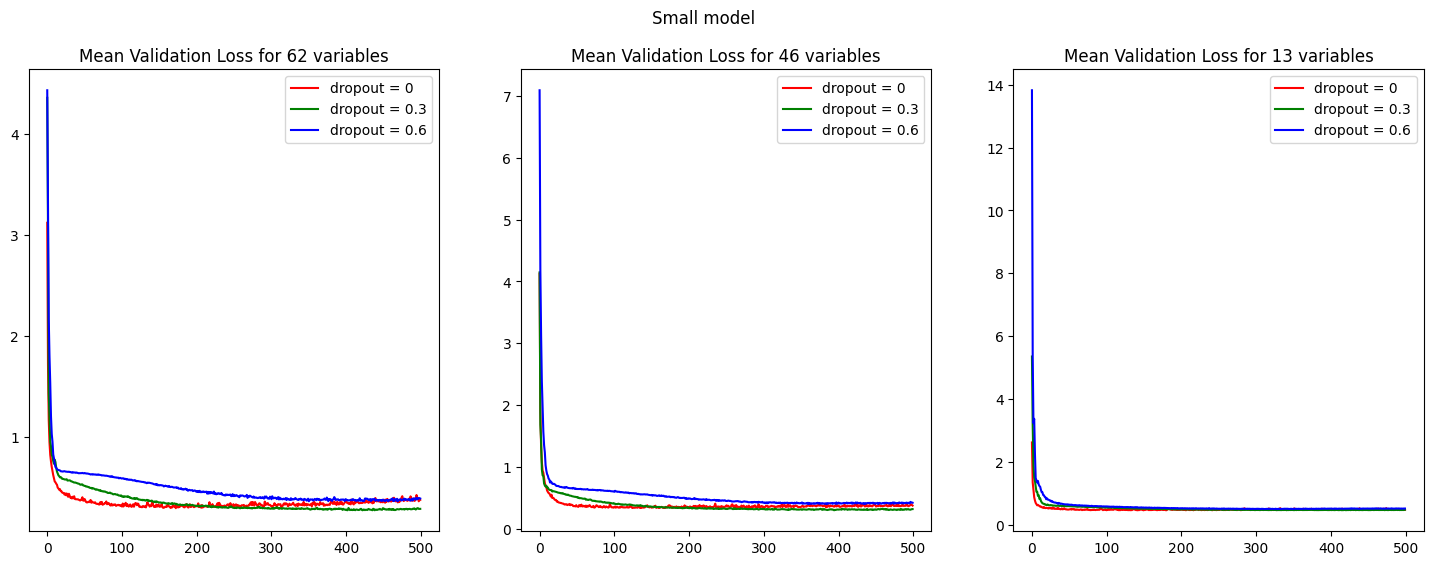

In [38]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Small model')
ax[0].set_title('Mean Validation Loss for 62 variables')
ax[0].plot(model62_2[0][0].mean_val_loss(), c = 'r')
ax[0].plot(model62_2[0][1].mean_val_loss(), c = 'g')
ax[0].plot(model62_2[0][2].mean_val_loss(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Loss for 46 variables')
ax[1].plot(model46_2[0][0].mean_val_loss(), c = 'r')
ax[1].plot(model46_2[0][1].mean_val_loss(), c = 'g')
ax[1].plot(model46_2[0][2].mean_val_loss(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Loss for 13 variables')
ax[2].plot(model13_2[0][0].mean_val_loss(), c = 'r')
ax[2].plot(model13_2[0][1].mean_val_loss(), c = 'g')
ax[2].plot(model13_2[0][2].mean_val_loss(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

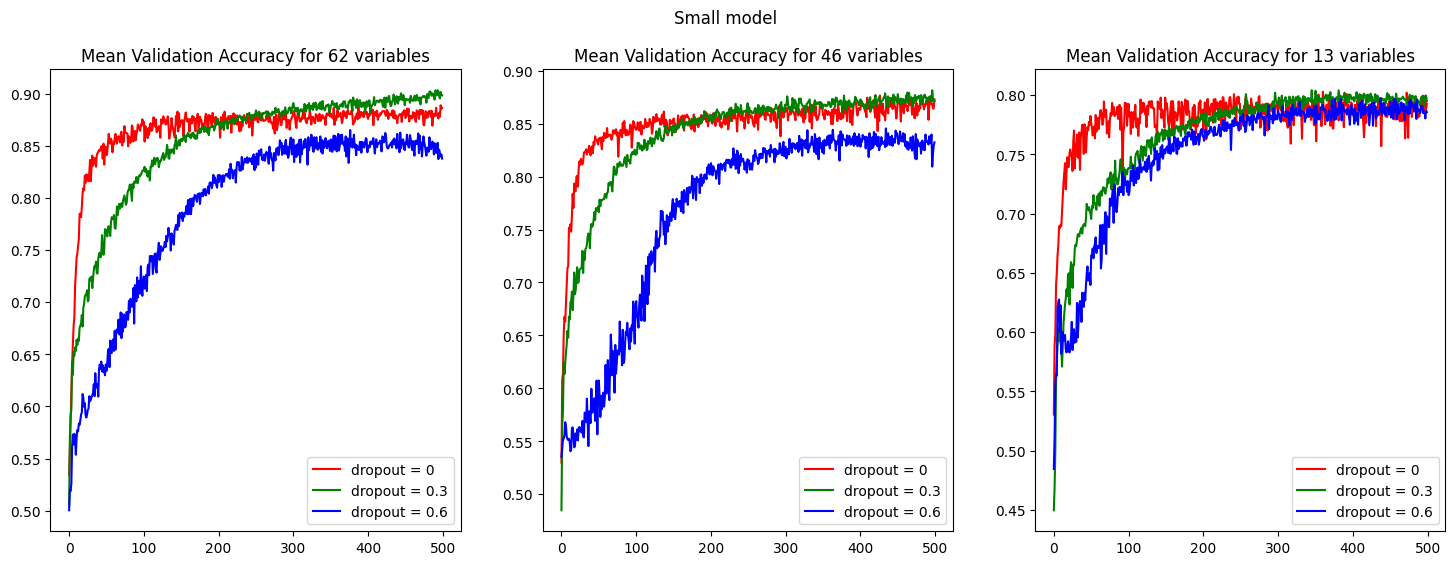

In [39]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Small model')
ax[0].set_title('Mean Validation Accuracy for 62 variables')
ax[0].plot(model62_2[0][0].mean_val_acc(), c = 'r')
ax[0].plot(model62_2[0][1].mean_val_acc(), c = 'g')
ax[0].plot(model62_2[0][2].mean_val_acc(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Accuracy for 46 variables')
ax[1].plot(model46_2[0][0].mean_val_acc(), c = 'r')
ax[1].plot(model46_2[0][1].mean_val_acc(), c = 'g')
ax[1].plot(model46_2[0][2].mean_val_acc(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Accuracy for 13 variables')
ax[2].plot(model13_2[0][0].mean_val_acc(), c = 'r')
ax[2].plot(model13_2[0][1].mean_val_acc(), c = 'g')
ax[2].plot(model13_2[0][2].mean_val_acc(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

We can see that for small model, moderate or no regularization give the best results

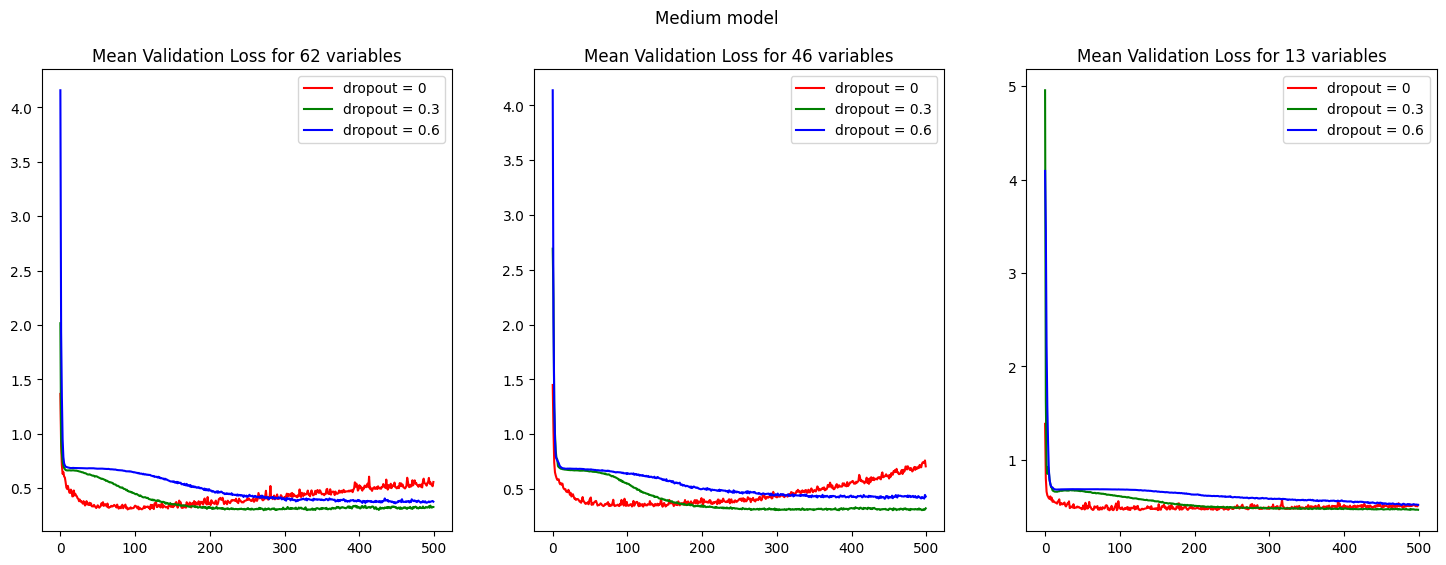

In [40]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Medium model')
ax[0].set_title('Mean Validation Loss for 62 variables')
ax[0].plot(model62_2[1][0].mean_val_loss(), c = 'r')
ax[0].plot(model62_2[1][1].mean_val_loss(), c = 'g')
ax[0].plot(model62_2[1][2].mean_val_loss(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Loss for 46 variables')
ax[1].plot(model46_2[1][0].mean_val_loss(), c = 'r')
ax[1].plot(model46_2[1][1].mean_val_loss(), c = 'g')
ax[1].plot(model46_2[1][2].mean_val_loss(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Loss for 13 variables')
ax[2].plot(model13_2[1][0].mean_val_loss(), c = 'r')
ax[2].plot(model13_2[1][1].mean_val_loss(), c = 'g')
ax[2].plot(model13_2[1][2].mean_val_loss(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

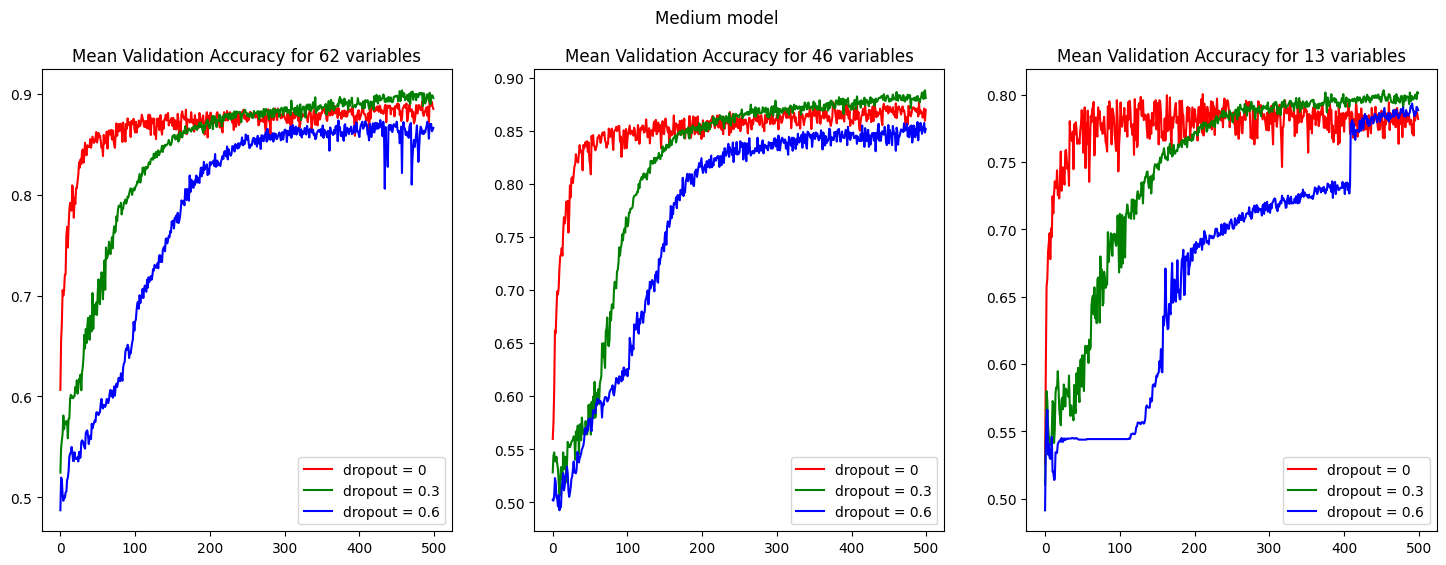

In [41]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Medium model')
ax[0].set_title('Mean Validation Accuracy for 62 variables')
ax[0].plot(model62_2[1][0].mean_val_acc(), c = 'r')
ax[0].plot(model62_2[1][1].mean_val_acc(), c = 'g')
ax[0].plot(model62_2[1][2].mean_val_acc(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Accuracy for 46 variables')
ax[1].plot(model46_2[1][0].mean_val_acc(), c = 'r')
ax[1].plot(model46_2[1][1].mean_val_acc(), c = 'g')
ax[1].plot(model46_2[1][2].mean_val_acc(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Accuracy for 13 variables')
ax[2].plot(model13_2[1][0].mean_val_acc(), c = 'r')
ax[2].plot(model13_2[1][1].mean_val_acc(), c = 'g')
ax[2].plot(model13_2[1][2].mean_val_acc(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

For medium models, no regularization causes overfitting - this is visible very well when we look at how validation loss starts to rise, specifically for models with more variables. Too big regularization causes underfitting, because loss function keeps on dropping very slowly, especially compared to 0.3 dropout.

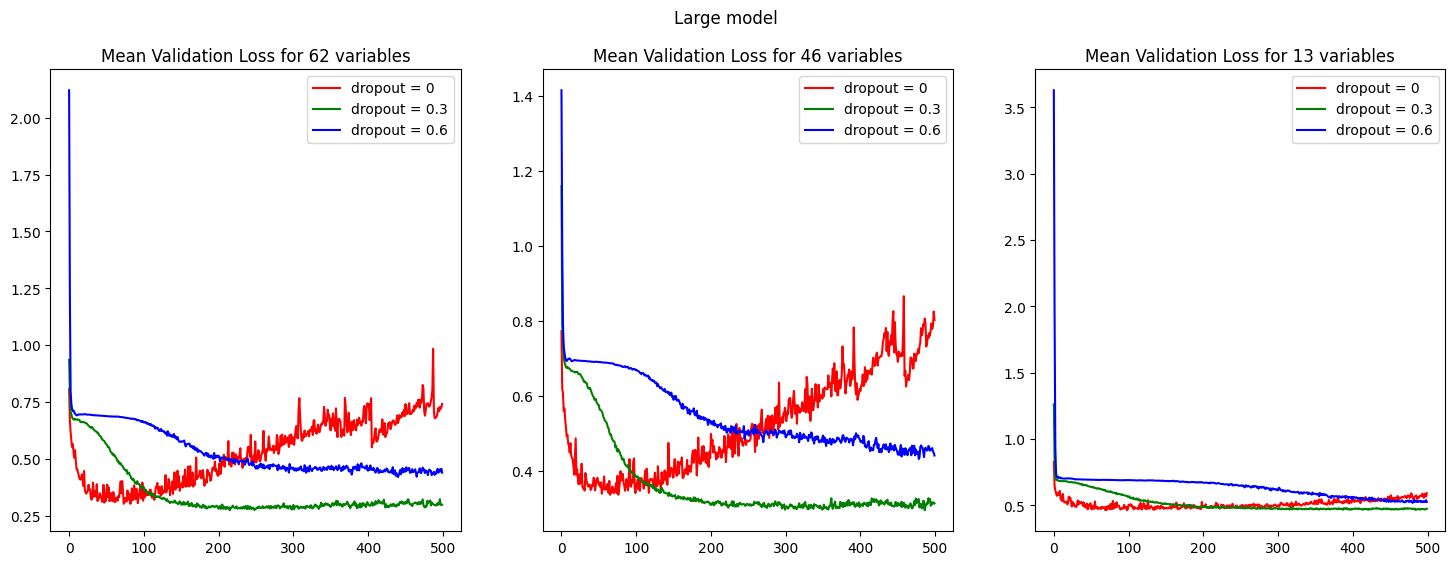

In [42]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Large model')
ax[0].set_title('Mean Validation Loss for 62 variables')
ax[0].plot(model62_2[2][0].mean_val_loss(), c = 'r')
ax[0].plot(model62_2[2][1].mean_val_loss(), c = 'g')
ax[0].plot(model62_2[2][2].mean_val_loss(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Loss for 46 variables')
ax[1].plot(model46_2[2][0].mean_val_loss(), c = 'r')
ax[1].plot(model46_2[2][1].mean_val_loss(), c = 'g')
ax[1].plot(model46_2[2][2].mean_val_loss(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Loss for 13 variables')
ax[2].plot(model13_2[2][0].mean_val_loss(), c = 'r')
ax[2].plot(model13_2[2][1].mean_val_loss(), c = 'g')
ax[2].plot(model13_2[2][2].mean_val_loss(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

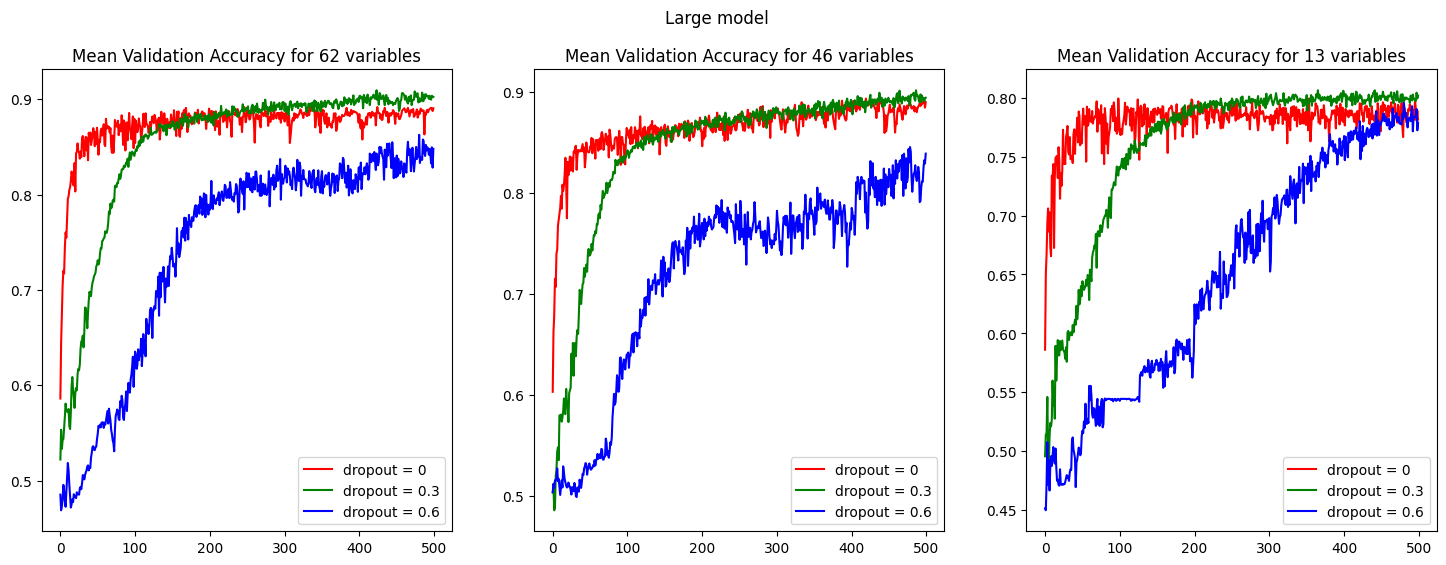

In [43]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Large model')
ax[0].set_title('Mean Validation Accuracy for 62 variables')
ax[0].plot(model62_2[2][0].mean_val_acc(), c = 'r')
ax[0].plot(model62_2[2][1].mean_val_acc(), c = 'g')
ax[0].plot(model62_2[2][2].mean_val_acc(), c = 'b')
ax[0].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[1].set_title('Mean Validation Accuracy for 46 variables')
ax[1].plot(model46_2[2][0].mean_val_acc(), c = 'r')
ax[1].plot(model46_2[2][1].mean_val_acc(), c = 'g')
ax[1].plot(model46_2[2][2].mean_val_acc(), c = 'b')
ax[1].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

ax[2].set_title('Mean Validation Accuracy for 13 variables')
ax[2].plot(model13_2[2][0].mean_val_acc(), c = 'r')
ax[2].plot(model13_2[2][1].mean_val_acc(), c = 'g')
ax[2].plot(model13_2[2][2].mean_val_acc(), c = 'b')
ax[2].legend(['dropout = 0', 'dropout = 0.3', 'dropout = 0.6'])

plt.show()

The effects of underfitting for high regularization rate and overfitting for no regularization are enhanced even more in large models when compared to medium models. Dropout 0.3 is a sensible option regardless of model size.

In [44]:
results46 = [model46_2[i][j].mean_val_acc()[-1] for i in range(len(dropouts)) for j in range(len(complexities))]
results46.extend([cv_acc46_l1, cv_acc46_l2])
results46 = pd.DataFrame(results46, index = names, columns = ['46 variables'])

results13 = [model13_2[i][j].mean_val_acc()[-1] for i in range(len(dropouts)) for j in range(len(complexities))]
results13.extend([cv_acc13_l1, cv_acc13_l2])
results13 = pd.DataFrame(results13, index = names, columns = ['13 variables'])

results62 = [model62_2[i][j].mean_val_acc()[-1] for i in range(len(dropouts)) for j in range(len(complexities))]
results62.extend([cv_acc62_l1, cv_acc62_l2])
results62 = pd.DataFrame(results62, index = names, columns = ['62 variables'])

Below we can see validation accuracy of all models. We can easily see, that small model gives the lowest valiation accuracy, while medium and large models give comparable results. In all cases, dropout 0.3 gave the best results when compared to other regularizations.

In [45]:
results = pd.concat([results62, results46, results13], axis=1)
results

,62 variables,46 variables,13 variables
"small model, dropout = 0",0.886475,0.872951,0.792623
"small model, dropout = 0.3",0.898361,0.871311,0.795082
"small model, dropout = 0.6",0.837705,0.832377,0.785656
"medium model, dropout = 0",0.884836,0.869672,0.781967
"medium model, dropout = 0.3",0.895492,0.880738,0.801230
"medium model, dropout = 0.6",0.865984,0.851639,0.788525
"large model, dropout = 0",0.890574,0.889754,0.781557
"large model, dropout = 0.3",0.902459,0.894262,0.802049
"large model, dropout = 0.6",0.847951,0.838934,0.779098
LR_l1,0.881557,0.867213,0.792213


In [46]:
results62.sort_values(by = '62 variables', ascending = False)

,62 variables
"large model, dropout = 0.3",0.902459
"small model, dropout = 0.3",0.898361
"medium model, dropout = 0.3",0.895492
"large model, dropout = 0",0.890574
"small model, dropout = 0",0.886475
"medium model, dropout = 0",0.884836
LR_l2,0.884426
LR_l1,0.881557
"medium model, dropout = 0.6",0.865984
"large model, dropout = 0.6",0.847951


In [47]:
results46.sort_values(by = '46 variables', ascending = False)

,46 variables
"large model, dropout = 0.3",0.894262
"large model, dropout = 0",0.889754
"medium model, dropout = 0.3",0.880738
"small model, dropout = 0",0.872951
"small model, dropout = 0.3",0.871311
"medium model, dropout = 0",0.869672
LR_l2,0.867213
LR_l1,0.867213
"medium model, dropout = 0.6",0.851639
"large model, dropout = 0.6",0.838934


In [48]:
results13.sort_values(by = '13 variables', ascending = False)

,13 variables
"large model, dropout = 0.3",0.802049
"medium model, dropout = 0.3",0.801230
"small model, dropout = 0.3",0.795082
"small model, dropout = 0",0.792623
LR_l1,0.792213
LR_l2,0.791393
"medium model, dropout = 0.6",0.788525
"small model, dropout = 0.6",0.785656
"medium model, dropout = 0",0.781967
"large model, dropout = 0",0.781557


When split by data size, deep neural network architecture with 0.3 dropout rate always gives the best results.

In [49]:
results.unstack().nlargest(10)

62 variables  large model, dropout = 0.3     0.902459
              small model, dropout = 0.3     0.898361
              medium model, dropout = 0.3    0.895492
46 variables  large model, dropout = 0.3     0.894262
62 variables  large model, dropout = 0       0.890574
46 variables  large model, dropout = 0       0.889754
62 variables  small model, dropout = 0       0.886475
              medium model, dropout = 0      0.884836
              LR_l2                          0.884426
              LR_l1                          0.881557
dtype: float64

Overall, the best result gives large neural network model with dropout rate 0.3 - accuracy around 0.9. In the top 10 we can also find both logistic regressions with accuracy on level 0.88.

To summarize, while model selection is important, one may argue that feature selection is equally or even more important. When using small dataset we lost a lot of information regarding prediction and average accuracy of models was around 0.8. It is also worth noting, that accuracies of models that were using the same dataset didn't differ much.

In [50]:
end = time()
ntime = end - start
print(f"Notebook finished working in {int(ntime//3600)}h {int((ntime%3600)//60)}min {int(ntime%60)}s")

Notebook finished working in 0h 1min 31s
